In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import (accuracy_score, roc_auc_score, classification_report,
                             confusion_matrix, roc_curve, auc)

from sklearn.ensemble import StackingClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Plot style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)


In [2]:
# Load dataset immediately
data_path = 'C:\\Users\\91837\\Music\\thyroid_cancer_risk_data.csv'
df = pd.read_csv(data_path)

# Target and features
X = df.drop(['Patient_ID', 'Diagnosis', 'Thyroid_Cancer_Risk'], axis=1)
y = df['Diagnosis'].map({'Benign': 0, 'Malignant': 1}).values

In [ ]:
# Define categorical and numerical features
categorical_features = ['Gender', 'Country', 'Ethnicity', 'Family_History',
                        'Radiation_Exposure', 'Iodine_Deficiency', 'Smoking',
                        'Obesity', 'Diabetes']
    numerical_features = ['Age', 'TSH_Level', 'T3_Level', 'T4_Level', 'Nodule_Size']

# Create preprocessor
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_features)
])


In [4]:
# Define base learners
base_learners = [
    ('hgb', HistGradientBoostingClassifier(max_iter=200, early_stopping=True, random_state=42)),
    ('lgb', LGBMClassifier(n_estimators=150, learning_rate=0.05, random_state=42, n_jobs=-1)),
    ('xgb', XGBClassifier(n_estimators=100, learning_rate=0.1, use_label_encoder=False,
                          eval_metric='logloss', random_state=42, n_jobs=-1)),
    ('cb', CatBoostClassifier(iterations=100, learning_rate=0.1, depth=5,
                              verbose=0, random_state=42))
]

# Define stacking classifier
stacking = StackingClassifier(
    estimators=base_learners,
    final_estimator=LogisticRegression(max_iter=1000, class_weight='balanced'),
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    passthrough=True
)

# Complete pipeline
pipeline = Pipeline([
    ('preproc', preprocessor),
    ('clf', stacking)
])


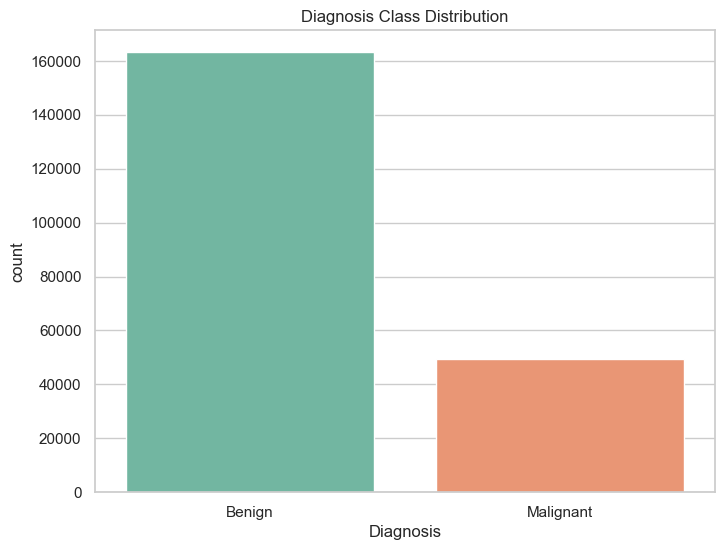

In [5]:
# Class distribution
sns.countplot(data=df, x='Diagnosis', palette='Set2')
plt.title('Diagnosis Class Distribution')
plt.show()


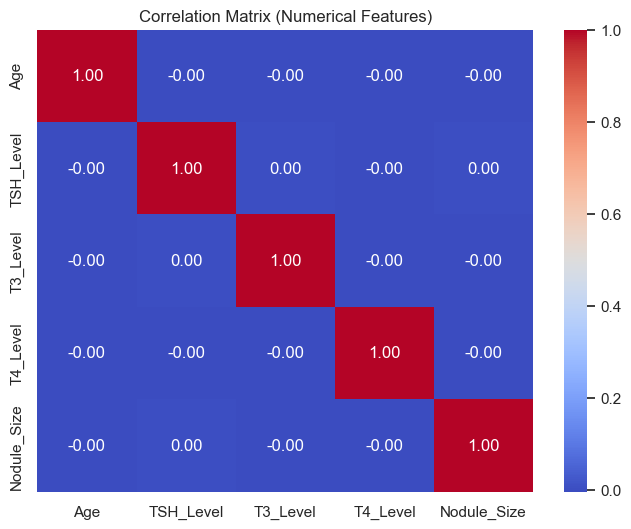

In [6]:
# Correlation heatmap
corr = df[numerical_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix (Numerical Features)')
plt.show()


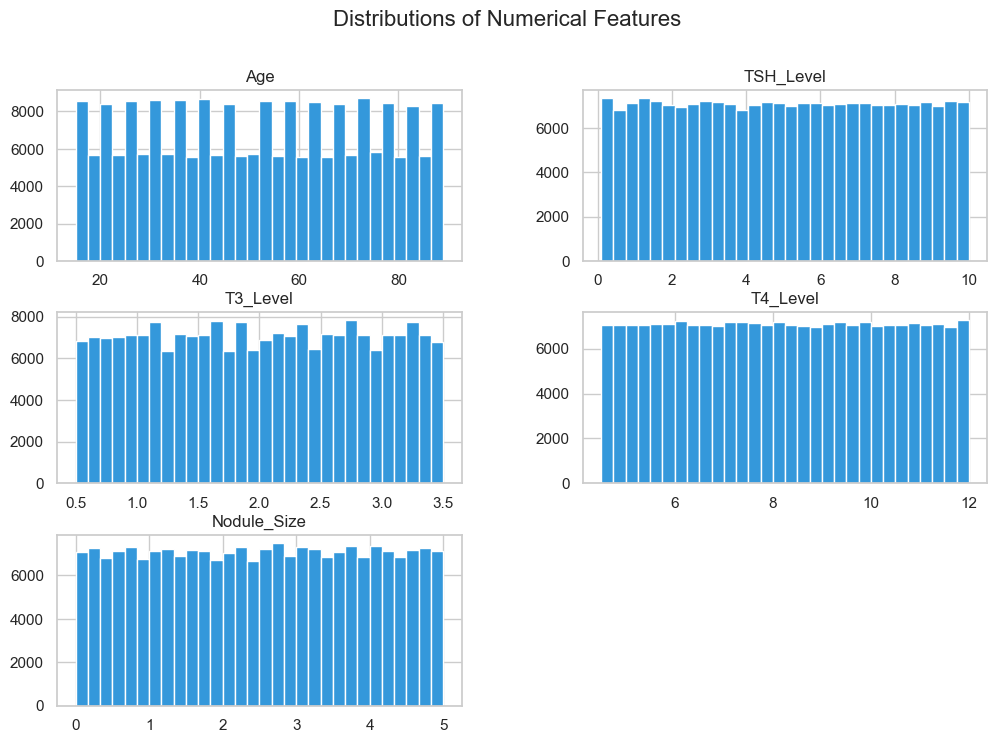

In [7]:
# Numerical distributions
df[numerical_features].hist(bins=30, figsize=(12, 8), color='#3498db')
plt.suptitle('Distributions of Numerical Features', fontsize=16)
plt.show()


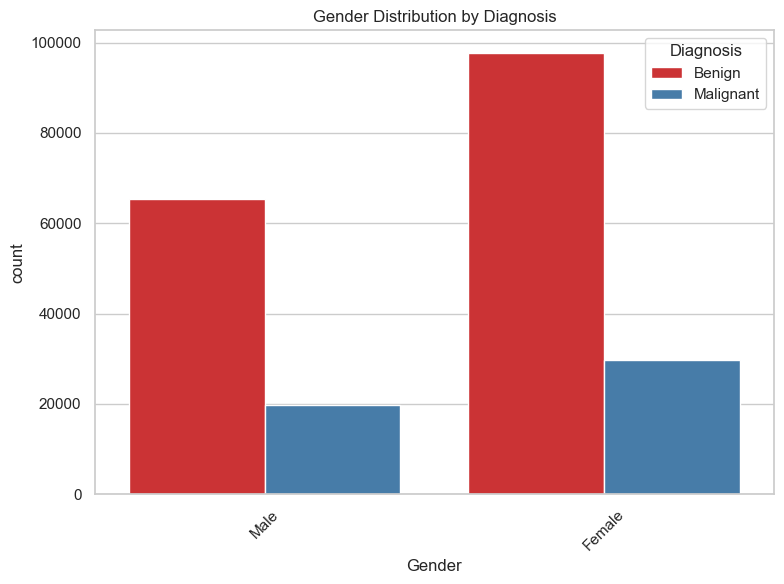

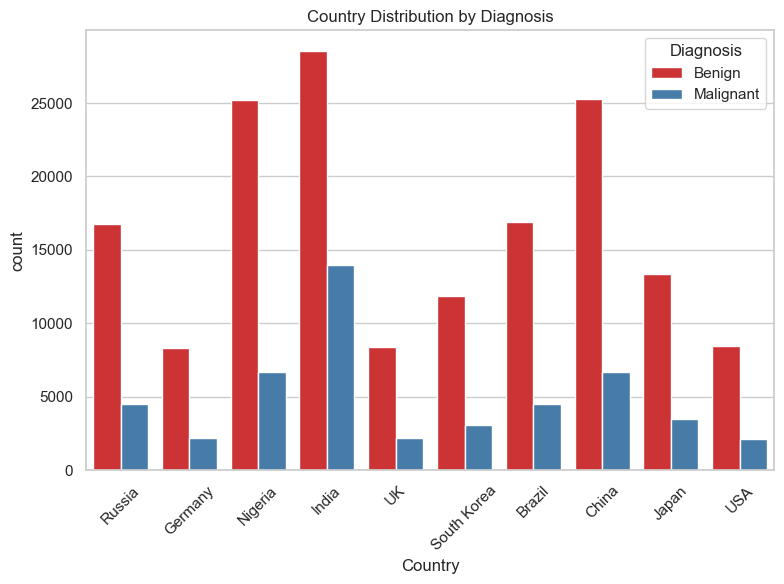

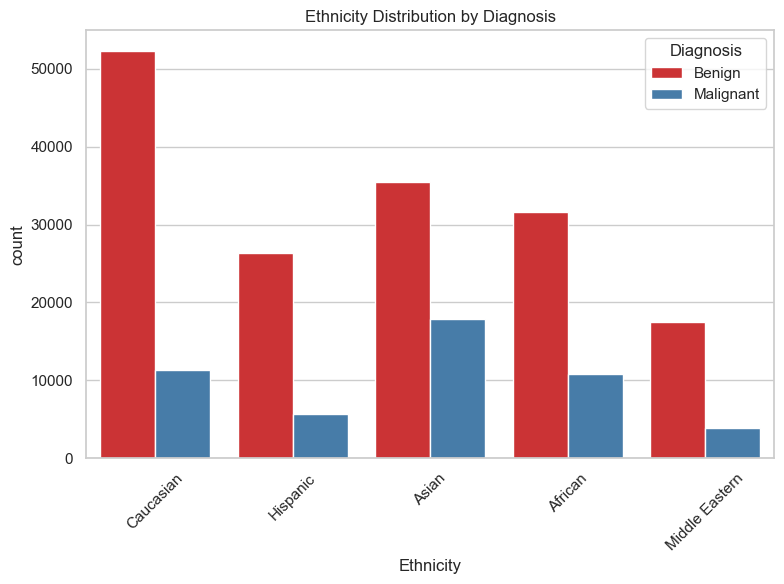

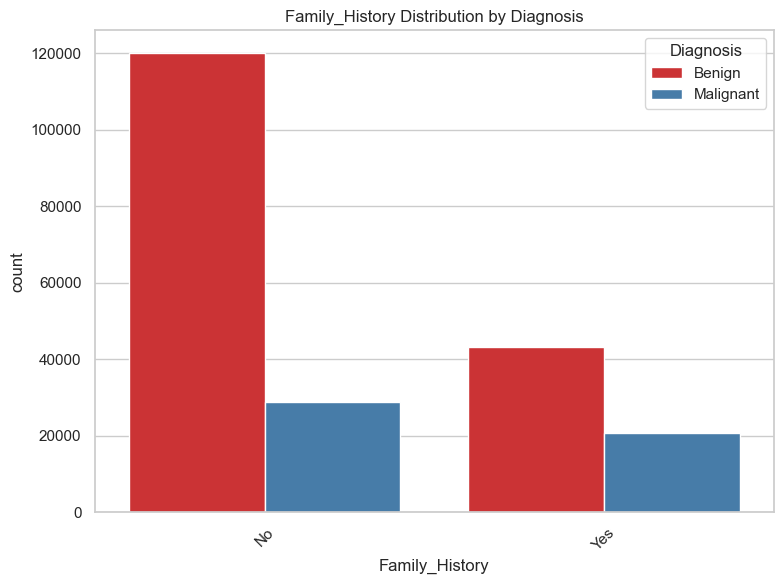

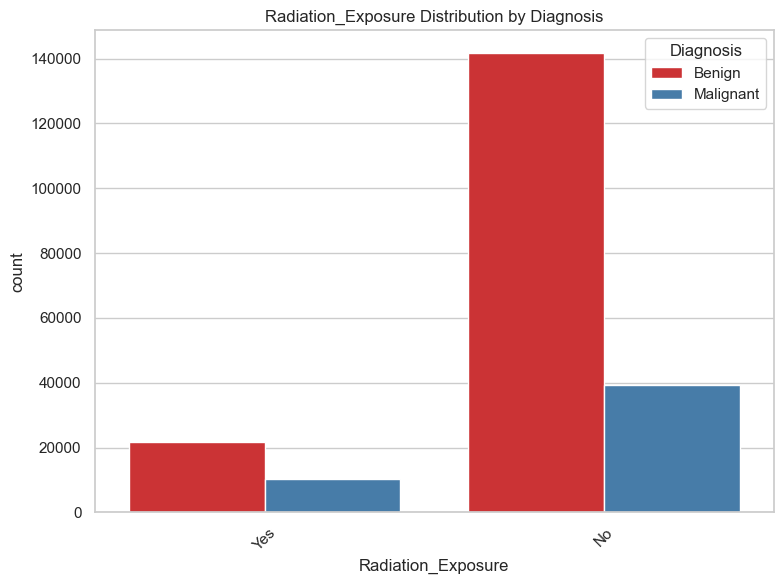

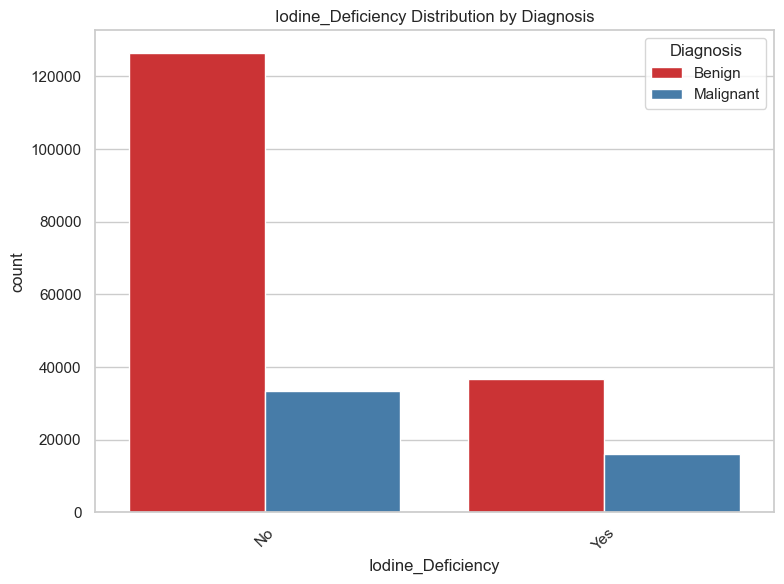

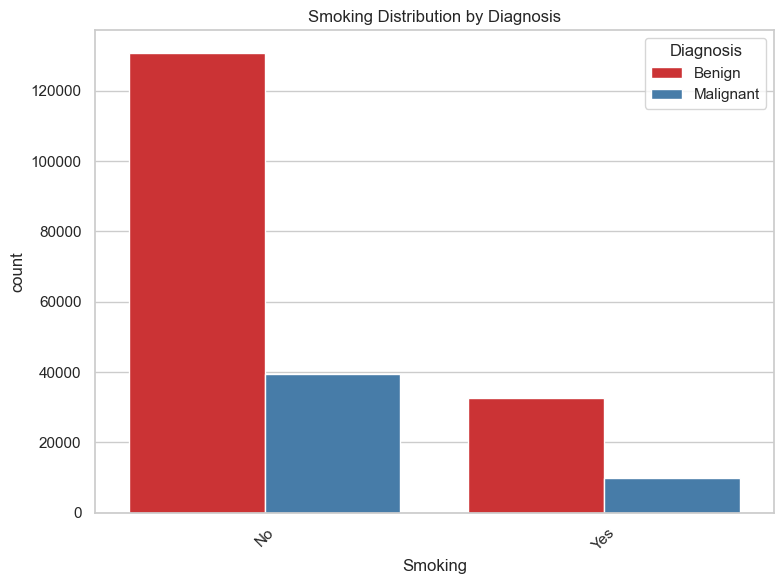

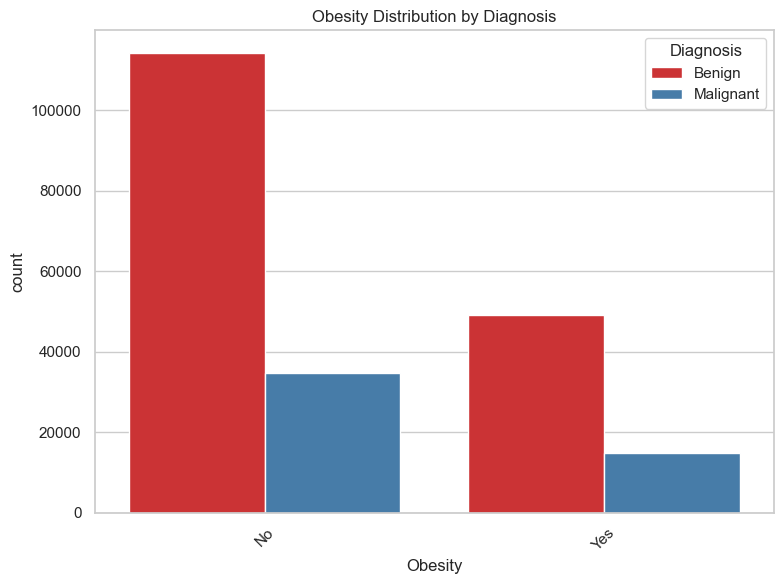

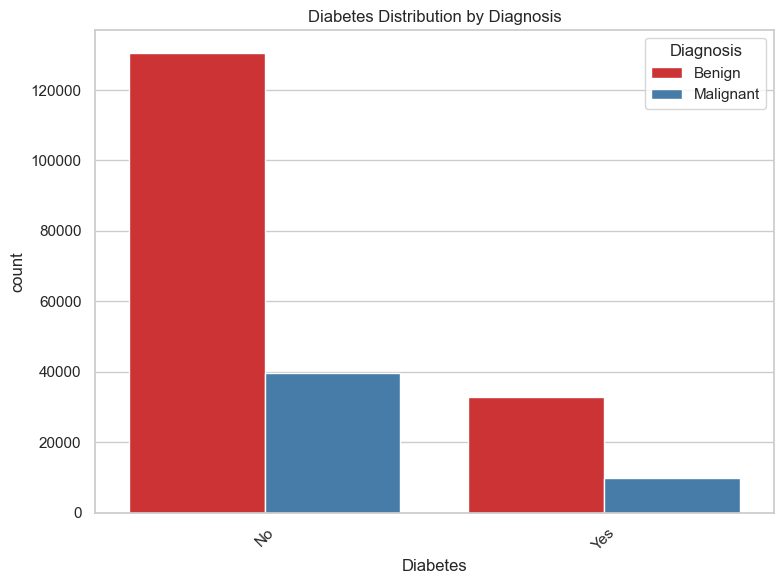

In [8]:
# Categorical features by diagnosis
for col in categorical_features:
    sns.countplot(data=df, x=col, hue='Diagnosis', palette='Set1')
    plt.title(f'{col} Distribution by Diagnosis')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [9]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Train the pipeline
print("Training stacking ensemble...")
pipeline.fit(X_train, y_train)


Training stacking ensemble...


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'TSH_Level',
                                                   'T3_Level', 'T4_Level',
                                                   'Nodule_Size']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Gender', 'Country',
                                                   'Ethnicity',
                                                   'Family_History',
                                                   'Radiation_Exposure',
                                                   'Iodine_Deficiency',
                                                   'Smoking', 'Obesity',
                                                   'Diabetes'])])),
                ('clf',
                 St...
                                                               max_delta_step=None,
                                                               max_depth=None,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=100,
                                                               n_jobs=-1,
                                                               num_parallel_tree=None, ...)),
                                                ('cb',
                                                 <catboost.core.CatBoostClassifier object at 0x000002BC10935650>)],
                                    final_estimator=LogisticRegression(class_weight='balanced',
                                                                       max_iter=1000),
                                    n_jobs=-1, passthrough=True))])

In [10]:
# Make predictions
preds = pipeline.predict(X_test)
probs = pipeline.predict_proba(X_test)[:, 1]

# Metrics
acc = accuracy_score(y_test, preds)
auc_score = roc_auc_score(y_test, probs)

print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC: {auc_score:.4f}")
print(classification_report(y_test, preds))


Accuracy: 0.8293
ROC-AUC: 0.7010
              precision    recall  f1-score   support

           0       0.85      0.94      0.89     32640
           1       0.71      0.46      0.55      9899

    accuracy                           0.83     42539
   macro avg       0.78      0.70      0.72     42539
weighted avg       0.82      0.83      0.82     42539



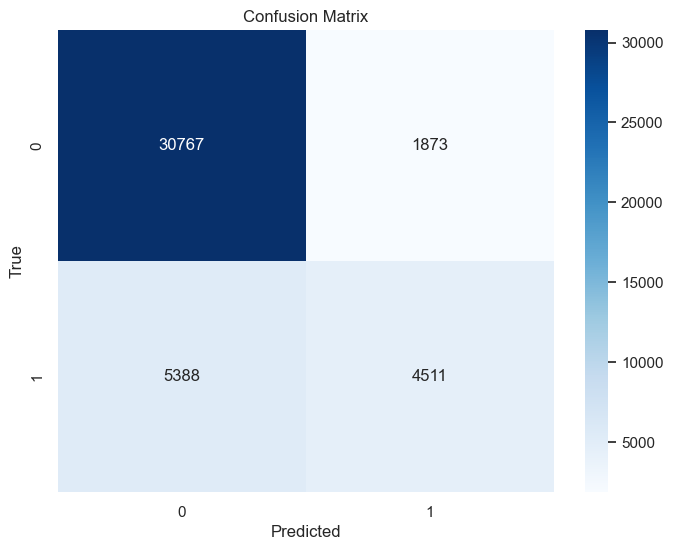

In [11]:
# Confusion matrix
cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


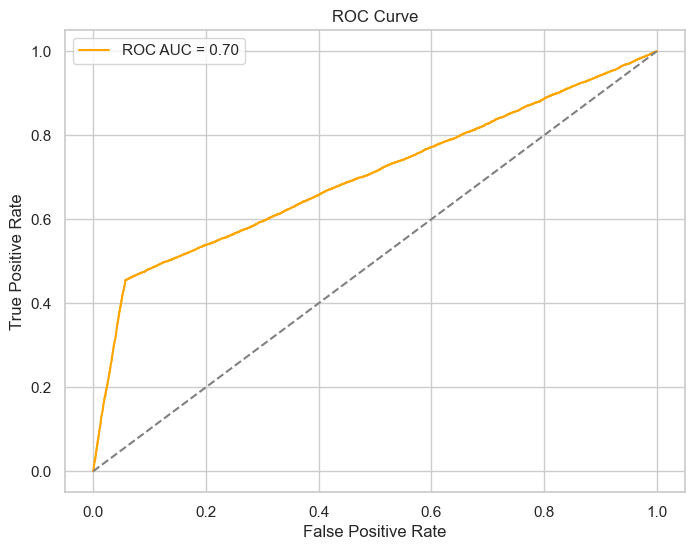

In [12]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}', color='orange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [ ]:
with open('stacked_full_model1.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

print("Model saved to 'stacked_full_model.pkl'")


Model saved to 'stacked_full_model1.pkl'


In [28]:
def predict(patient_data, model_path='stacked_full_model1.pkl'):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)

    df = pd.DataFrame([patient_data])
    X_proc = df[numerical_features + categorical_features]
    prob = model.predict_proba(X_proc)[0, 1]
    pred = int(prob > 0.5)

    risk = ('Very Low' if prob < 0.2 else 'Low' if prob < 0.4 else
            'Moderate' if prob < 0.6 else 'High' if prob < 0.8 else 'Very High')

    return {
        'diagnosis': 'Malignant' if pred else 'Benign',
        'probability': float(prob),
        'risk_level': risk
    }


In [29]:
# Sample patient dictionary (no extra spaces here)
sample_patient = {
    'Gender': 'Female',
    'Age': 45,
    'Country': 'USA',
    'Ethnicity': 'Caucasian',
    'Family_History': 'No',
    'Radiation_Exposure': 'No',
    'Iodine_Deficiency': 'No',
    'Smoking': 'No',
    'Obesity': 'No',
    'Diabetes': 'No',
    'TSH_Level': 2.5,
    'T3_Level': 120,    # Should be numeric, not float
    'T4_Level': 8.5,
    'Nodule_Size': 0.8
}

# Correct function call (no indent here)
prediction_result = predict(sample_patient)

# Display results (also no indent)
print("Prediction result:")
print(f"Diagnosis: {prediction_result.get('diagnosis')}")
print(f"Probability: {prediction_result.get('probability'):.4f}")
print(f"Risk Level: {prediction_result.get('risk_level')}")


Prediction result:
Diagnosis: Benign
Probability: 0.3083
Risk Level: Low
